In [1]:
import tensorflow as tf
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_dir =  'C:/10449_44567_bundle_archive/training/training/'
val_dir = 'C:/10449_44567_bundle_archive/validation/validation/'
label_dir = "C:/10449_44567_bundle_archive/monkey_labels.txt"

txt 파일도 그냥 pd.read_csv로 읽어가는 것이 충분히 가능하다.

현재 train_dir과 val_dir에 각각에 원숭이 10종이 세분화되어서 저장이 되어 있다.

In [3]:
full_data = pd.read_csv(label_dir)
full_data.head()

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26


In [124]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Label                            10 non-null     object
 1     Latin Name                     10 non-null     object
 2    Common Name                     10 non-null     object
 3    Train Images                    10 non-null     int64 
 4    Validation Images               10 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 528.0+ bytes


In [129]:
full_data.columns

Index(['Label', '  Latin Name           ', ' Common Name                   ',
       ' Train Images ', ' Validation Images'],
      dtype='object')

#### X, y 데이터셋 만들기(각 사진에 맞게 label 제대로 설정하는 것이 중요)

In [4]:
new_size = 224
batch = 32

In [5]:
os.path.join(train_dir, full_data['Label'][0].strip(' '))

'C:/10449_44567_bundle_archive/training/training/n0'

In [89]:
x_train,y_train = [],[]
x_val, y_val = [],[]
for i in range(10):
    dire_1 = os.path.join(train_dir, full_data['Label'][i].strip(' '))
    dire_2 = os.path.join(val_dir, full_data['Label'][i].strip(' '))
    every_1 = os.listdir(dire_1)
    every_2 = os.listdir(dire_2)
    for p in every_1:
        k = os.path.join(dire_1, p)
        img = cv2.imread(k, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (new_size, new_size))
        x_train.append(img)
        y_train.append(i)
    for p in every_2:
        k = os.path.join(dire_2, p)
        img = cv2.imread(k, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (new_size, new_size))
        x_val.append(img)
        y_val.append(i)

    
        
        


In [92]:
len(x_train)

1098

#### Image Data Generator 만들기 및 적용

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1/255,
)

test_gen = ImageDataGenerator(rescale = 1/255)
val_gen = ImageDataGenerator(rescale = 1/255)

In [94]:
from tensorflow.keras.utils import to_categorical

In [95]:
x_train = np.array(x_train, dtype = 'float32').reshape(-1,new_size, new_size, 3)
x_val = np.array(x_val, dtype = 'float32').reshape(-1,new_size, new_size, 3)
y_train = np.asarray(y_train).reshape(x_train.shape[0])
y_val = np.asarray(y_val).reshape(x_val.shape[0])
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [97]:
x_train.shape

(1098, 224, 224, 3)

CNN 신경망에 적용시키기 위해서는 아닌 경우도 존재 하겠지만 주로 4차원 형태의 이미지로 변환을 해야 하기 때문에 주어진 값을 (-1, new_size, new_size, 3)으로 변경한다. 

그리고 x데이터의 이미지 파일을 리스트에 저장할때 resize를 반드시 해야 하는 이유는 모든 이미지가 크기가 같은 것이 아니기 때문에 반드시 크기를 맞춰주어야 하는 것이다.

마지막으로 y값도 reshaping을 해야 하는데 그 이유는 나중에 fitting을 할 때에 x의 데이터와 len()값이 일치해야만 학습과 훈련이 가능하기 때문이다. 학습이전에 이미 ImageDataGenerator에서 매칭이 안되면 에러가 발생한다.

In [98]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train)

In [99]:
x_test.shape

(275, 224, 224, 3)

In [100]:
train_gen.fit(x_train)

In [101]:
train_set = train_gen.flow(
    x_train, y_train,
    batch_size=batch,
    shuffle=True,
    seed=None,
    save_to_dir=None
)

test_set = test_gen.flow(x_test, y_test)
val_set = val_gen.flow(x_val, y_val)

#### 모델 설계하기(CNN)

In [102]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D,Activation,Flatten,Dense,Dropout
model = tf.keras.models.Sequential()
model.add(Conv2D(input_shape = (224,224,3), filters = 50, kernel_size = (3,3), strides = (2,2),activation = 'relu', padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 100, kernel_size = (3,3), strides = (2,2), activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 200, kernel_size = (3,3), strides = (2,2), activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

#Dense Layer에 적용하기 위해 4차원 데이터의 차원수를 줄인다.
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [103]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 112, 112, 50)      1400      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 56, 56, 50)        0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 56, 56, 50)        200       
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 28, 28, 100)       45100     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 14, 14, 100)       0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 14, 14, 100)       400       
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 7, 7, 200)       

In [104]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_percentage_error
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 20)
reduce = ReduceLROnPlateau(monitor = 'val_loss', patience = 10, verbose = 1, min_lr = 0.00001)


model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

학습을 진행하는 와중에 첫번째 시도만에 val_accuracy가 1이 나왔었는데 학습이 잘된 것이 아니라 validation data가 shuffle이 되지 않은 상황이었다. 그래서 다시 아래 코드를 넣고 섞은 뒤에 한번더 시도를 했더니 역시나 val_accuracy가 16.91%로 첫 시작을 하였다.

In [105]:
index = np.arange(x_val.shape[0])
np.random.shuffle(index)
x_val = x_val[index]
y_val = y_val[index]
val_set = val_gen.flow(x_val, y_val)

In [106]:
history = model.fit(train_set, validation_data = val_set, 
                    steps_per_epoch = len(x_train)//batch, callbacks = [early_stop, reduce], epochs = 30)

Train for 25 steps, validate for 9 steps
Epoch 1/30
25/25 [==============================] - 23s 931ms/step - loss: 2.5118 - accuracy: 0.1820 - val_loss: 2.3003 - val_accuracy: 0.1213
Epoch 2/30
25/25 [==============================] - 21s 822ms/step - loss: 2.1751 - accuracy: 0.2124 - val_loss: 2.3186 - val_accuracy: 0.1029
Epoch 3/30
25/25 [==============================] - 21s 851ms/step - loss: 2.1058 - accuracy: 0.2137 - val_loss: 2.4352 - val_accuracy: 0.1029
Epoch 4/30
25/25 [==============================] - 20s 807ms/step - loss: 2.0365 - accuracy: 0.2541 - val_loss: 2.5579 - val_accuracy: 0.1029
Epoch 5/30
25/25 [==============================] - 20s 815ms/step - loss: 1.9761 - accuracy: 0.2617 - val_loss: 2.7130 - val_accuracy: 0.1029
Epoch 6/30
25/25 [==============================] - 20s 805ms/step - loss: 2.0166 - accuracy: 0.2794 - val_loss: 2.9896 - val_accuracy: 0.1176
Epoch 7/30
25/25 [==============================] - 20s 799ms/step - loss: 1.8987 - accuracy: 0.2845 

In [107]:
model.evaluate(test_set)

9/9 [==============================] - 1s 110ms/step - loss: 1.3959 - accuracy: 0.5491


[1.3958550691604614, 0.5490909]

In [109]:
y_pred = model.predict(x_test)
y_pred

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [110]:
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

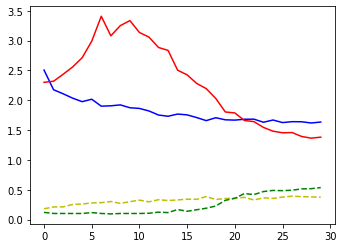

In [112]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r-', label = 'val_loss')
plt.plot(history.history['accuracy'], 'y--', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'g--', label = 'val_accuracy')

진행 상황을 보니 조금 더 epoch수를 늘렸다면 꽤 높은 정확도를 보일 것 같았다.

그래서 진행을 더했다. 이어져서 학습이 가능하기 때문이다.

In [114]:
history_re = model.fit(train_set, validation_data = val_set, 
                    steps_per_epoch = len(x_train)//batch, callbacks = [early_stop, reduce], epochs = 30)

Train for 25 steps, validate for 9 steps
Epoch 1/30
25/25 [==============================] - 20s 795ms/step - loss: 1.6307 - accuracy: 0.4008 - val_loss: 1.3857 - val_accuracy: 0.5074
Epoch 2/30
25/25 [==============================] - 23s 931ms/step - loss: 1.6688 - accuracy: 0.3692 - val_loss: 1.4097 - val_accuracy: 0.5074
Epoch 3/30
25/25 [==============================] - 22s 897ms/step - loss: 1.5907 - accuracy: 0.4046 - val_loss: 1.3639 - val_accuracy: 0.5147
Epoch 4/30
25/25 [==============================] - 22s 870ms/step - loss: 1.6046 - accuracy: 0.3825 - val_loss: 1.3803 - val_accuracy: 0.5037
Epoch 5/30
25/25 [==============================] - 21s 850ms/step - loss: 1.5903 - accuracy: 0.3805 - val_loss: 1.3962 - val_accuracy: 0.5074
Epoch 6/30
25/25 [==============================] - 20s 800ms/step - loss: 1.5582 - accuracy: 0.4058 - val_loss: 1.3654 - val_accuracy: 0.5294
Epoch 7/30
25/25 [==============================] - 20s 798ms/step - loss: 1.5757 - accuracy: 0.4109 

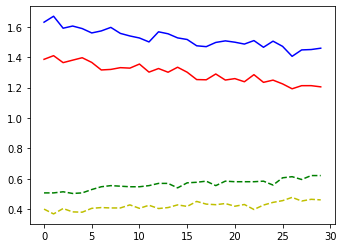

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,4))
plt.subplot(1,2,2)
plt.plot(history_re.history['loss'], 'b-', label = 'loss')
plt.plot(history_re.history['val_loss'], 'r-', label = 'val_loss')
plt.plot(history_re.history['accuracy'], 'y--', label = 'accuracy')
plt.plot(history_re.history['val_accuracy'], 'g--', label = 'val_accuracy')

In [120]:
y_pred = model.predict(x_test)
y_pred[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [140]:
len(y_pred)

275

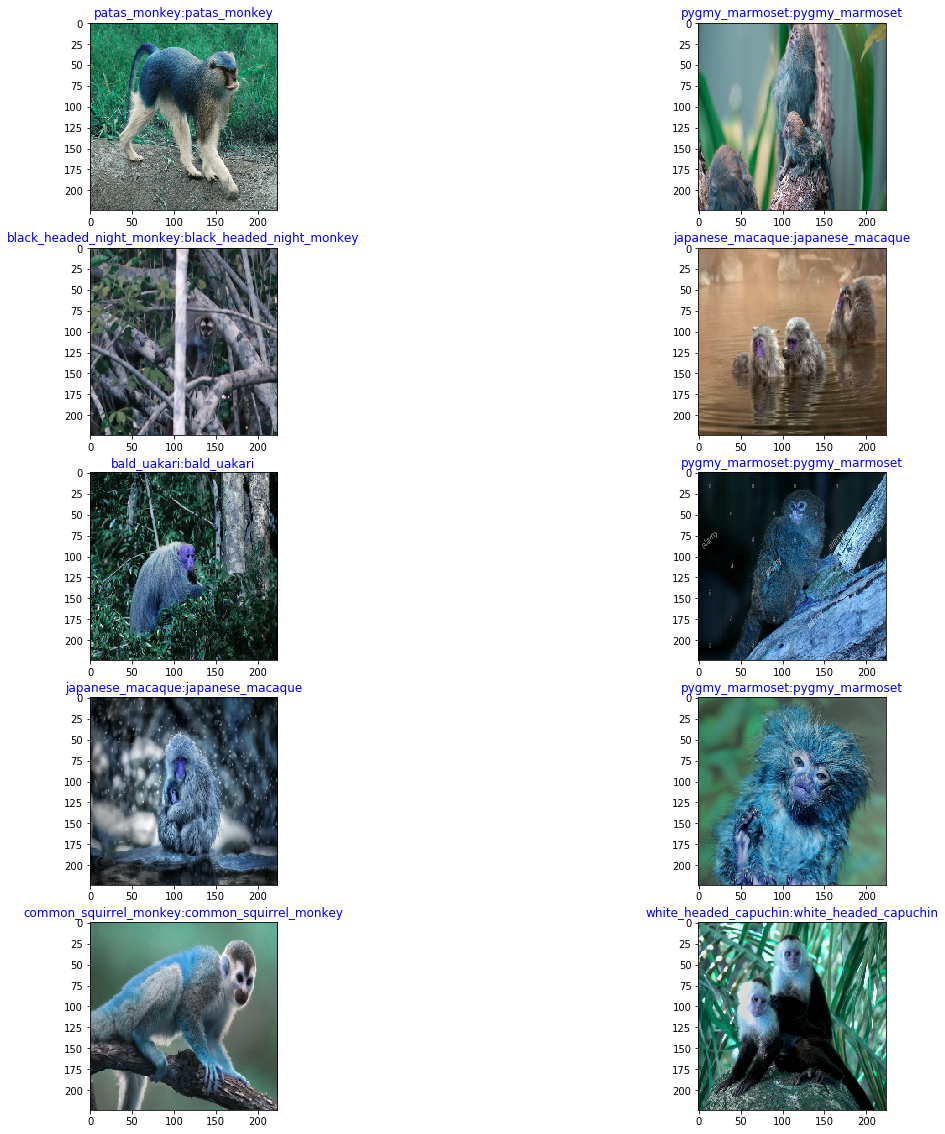

In [152]:
plt_index = 0
plt.figure(figsize = (20,20))
for i in range(2,252,25):
    plt_index += 1
    plt.subplot(5,2,plt_index)
    for k in range(10):
        if y_pred[i][k] == 1:
            now = k
            break
    for k in range(10):
        if y_test[i][k] == 1:
            noww = k
            break
    pred, ans = full_data[' Common Name                   '][k].strip(' '), full_data[' Common Name                   '][noww].strip(' ')
    plt.imshow(x_test[i]/255)
    if pred == ans:
        plt.title("%s:%s"%(pred, ans),color = 'b')
    else:
        plt.title("%s:%s"%(pred, ans), color = 'r')

evaluate의 accuracy는 58.18%였으나 직접 정답과 예측을 시각화 해본 결과 대부분의 학습 결과가 정답이었다.

In [153]:
model.evaluate(test_set)

9/9 [==============================] - 1s 122ms/step - loss: 1.2479 - accuracy: 0.5818


[1.2478941016727023, 0.58181816]

#### VGG16 model 사용해보기

그러나 학습하는데 시간이 너무 많이 걸려서 그냥 학습을 마저 시키지는 않았다.

In [154]:
from tensorflow.keras.applications.vgg16 import VGG16
new_model = tf.keras.models.Sequential()
new_model.add(VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3)))
new_model.add(tf.keras.layers.Flatten())
new_model.add(tf.keras.layers.Dense(128, activation="relu"))
new_model.add(tf.keras.layers.Dense(64, activation="relu"))
new_model.add(tf.keras.layers.Dense(64, activation="relu"))
new_model.add(tf.keras.layers.Dense(10, activation="sigmoid"))
new_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               3211392   
_________________________________________________________________
dense_45 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 10)                650       
Total params: 17,939,146
Trainable params: 17,939,146
Non-trainable params: 0
_________________________________________